In [3]:
import pandas as pd
import scipy.stats
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datashader as ds
from matplotlib.backends.backend_pdf import PdfPages

sns.set(color_codes=True)
sns.set_palette("husl")
trans_flag_cmap = sns.diverging_palette(240, 348, s=79, l=64, as_cmap=True)
red_blue_cmap = sns.diverging_palette(220, 10, as_cmap=True)

diverging_map = red_blue_cmap

## Repo/fact data

In [4]:
df = pd.read_csv("repo-stats.csv")
df.rename(columns=lambda c: c.replace("min(2) ", ""), inplace=True)
df.rename(columns=lambda c: c.replace(" runtime", ""), inplace=True)
df.rename(columns={"program": "repository"}, inplace=True)
df.rename(columns={"regions": "prov.vars"}, inplace=True)
df.drop(["cfg density", "cfg transitivity", 
         "cfg number of attracting components",
         "universal_region"],
        inplace=True, axis=1)

In [5]:
df.columns

Index(['repository', 'function', 'Naive', 'Hybrid', 'DatafrogOpt',
       'borrow_region', 'cfg_edge', 'child', 'initialized_at', 'invalidates',
       'killed', 'moved_out_at', 'outlives', 'path_accessed_at',
       'path_belongs_to_var', 'var_defined', 'var_drop_used',
       'var_drops_region', 'var_used', 'var_uses_region', 'loans', 'variables',
       'prov.vars', 'cfg nodes'],
      dtype='object')

In [6]:
runtime_cols = ["Naive", 
                "Hybrid", 
                "DatafrogOpt",
               ]

In [7]:
df.dropna(inplace=True)

In [8]:
df[df["loans"] == 0].size / df.size

0.6403050286468904

We ignore any function with no loans:

In [9]:
df = df[df["loans"] >= 1]

In [10]:
large_df = df[(df["Naive"] >= 1) 
              & (df["Naive"] <= 50)]

In [11]:
large_df.sort_values(by="DatafrogOpt", ascending=False).head(n=5)

,repository,function,Naive,Hybrid,DatafrogOpt,borrow_region,cfg_edge,child,initialized_at,invalidates,...,path_belongs_to_var,var_defined,var_drop_used,var_drops_region,var_used,var_uses_region,loans,variables,prov.vars,cfg nodes
3005236,gleam,ffi-{{impl}}[1]-load_with,42.731282,42.197695,42.180267,1611,35449,0,5640,651250,...,6445,16915,2,0,6444,11274,1611,6445,41175,1614
3007405,gleam,ffi_gl-{{impl}}[1]-load_with,37.653864,37.406079,37.517239,1545,33997,0,5409,599077,...,6181,16222,2,0,6180,10812,1545,6181,39511,1548
2954262,gfx_gl,{{impl}}[1]-load_with,30.257967,29.614761,29.711762,1407,30961,0,4926,497026,...,5629,14773,2,0,5628,9846,1407,5629,36123,1410
1094991,grr,__gl-{{impl}}[1]-load_with,29.771712,29.368693,29.462559,1407,30961,0,4926,497026,...,5629,14773,2,0,5628,9846,1407,5629,36123,1410
3130026,http,header-name-parse_hdr,31.223810,54.582938,28.283312,69,157186,16694,28914,15853,...,27876,57687,0,0,49166,307,69,27845,940,14311


In [12]:
df[df["var_drop_used"] == 0].size / df.size

0.698289928717623

In [13]:
df["loans"].mean(), df["loans"].median()

(4.969448090902675, 2.0)

In [14]:
df.groupby("repository")[["var_drop_used", "loans", "var_used", "cfg nodes"]].max().median()

var_drop_used     45.0
loans             24.0
var_used         177.0
cfg nodes        125.0
dtype: float64

A box plot of the runtimes:

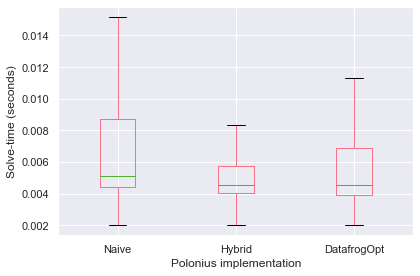

In [15]:
fig, ax = plt.subplots()
df.boxplot(column=runtime_cols, 
           showfliers=False
          )
ax.set_ylabel("Solve-time (seconds)")
ax.set_xlabel("Polonius implementation")
plt.tight_layout()
fig.savefig("../Report/Graphs/solvetimes_boxplot.pdf", bbox_inches='tight')

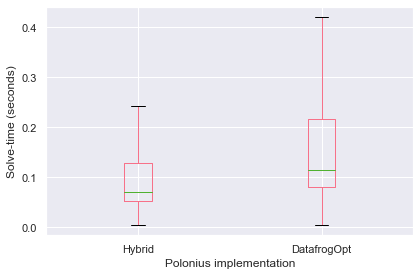

In [16]:
fig, ax = plt.subplots()
large_df.boxplot(column=["Hybrid", "DatafrogOpt"], 
           showfliers=False
          )
ax.set_ylabel("Solve-time (seconds)")
ax.set_xlabel("Polonius implementation")
plt.tight_layout()
fig.savefig("../Report/Graphs/solvetimes_boxplot_over_1s.pdf", bbox_inches='tight')

Give a histogram of the runtime of the three different algorithms:

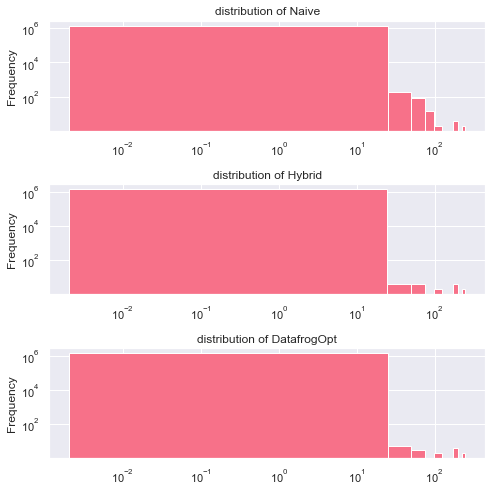

In [17]:
fig, axs = plt.subplots(3, sharey=True, sharex=False, figsize=(7,7))
for c, ax in zip(runtime_cols, axs):
    #ax = sns.distplot(df[c], ax=ax, kde=False, rug=True)
    df[c].plot.hist(ax=ax)
    ax.set_title(f"distribution of {c}")
    ax.set(xscale="log", yscale="log")
    
plt.tight_layout()
fig.savefig("../Report/Graphs/solvetimes_dist.pdf", bbox_inches='tight')

Geometric means of the runtime:

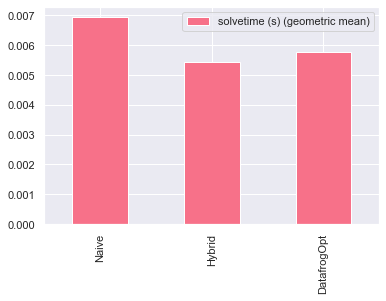

In [18]:
pd.DataFrame(scipy.stats.gmean(df[runtime_cols], axis=0), 
             index=runtime_cols, 
             columns=["solvetime (s) (geometric mean)"]).plot.bar()
plt.savefig("../Report/Graphs/solvetimes_fn_gmean.pdf", bbox_inches='tight')

## Input Data properties

The number of unique functions (hopefully the size of the data set):

In [19]:
df.groupby(["repository", "function"])\
    .size()\
    .reset_index()\
    .rename(columns={0:'count'})["count"]\
    .sum()

1416900

And the number of crates analysed:

In [20]:
df["repository"].nunique()

11687

Solvetime per repository:

In [21]:
repo_times = df.groupby(["repository"]).sum()[runtime_cols]

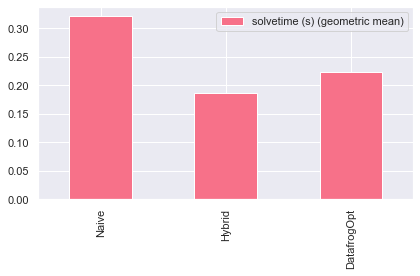

In [108]:
_ = pd.DataFrame(scipy.stats.gmean(repo_times, axis=0), 
             index=runtime_cols, 
             columns=["solvetime (s) (geometric mean)"]).plot.bar()
plt.tight_layout()
plt.savefig("../Report/Graphs/solvetimes_repo_gmean.pdf", bbox_inches='tight')

The median number of functions per repository:

In [23]:
df.groupby(["repository"]).size().median()

21.0

In [24]:
fact_cols = ['borrow_region', 'cfg_edge', 'child', 'initialized_at', 'invalidates',
       'killed', 'moved_out_at', 'outlives', 'path_accessed_at',
       'path_belongs_to_var', 'var_defined',
       'var_drops_region', 'var_used', 'var_uses_region',
       'loans', 'variables', 'prov.vars', 'cfg nodes']

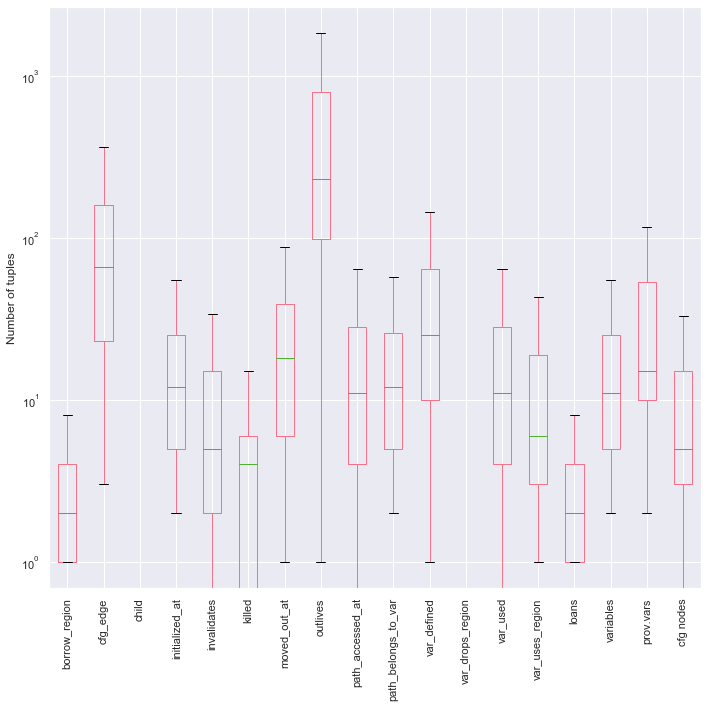

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
df.boxplot(column=fact_cols, 
           showfliers=False
          )
ax.set_ylabel("Number of tuples")
ax.set(yscale="log")
ax.set_xticklabels(fact_cols,rotation=90)

plt.tight_layout()
fig.savefig("../Report/Graphs/input_sizes_boxplot.pdf", bbox_inches='tight')

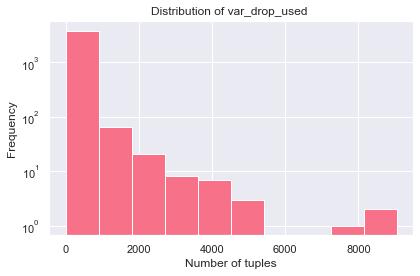

In [29]:
fig, ax = plt.subplots()
large_df["var_drop_used"].plot.hist(ax=ax)
ax.set_title("Distribution of var_drop_used ")
ax.set_xlabel("Number of tuples")
ax.set(yscale="log")
plt.tight_layout()
plt.savefig("../Report/Graphs/var_drop_used_size_dist.pdf", bbox_inches='tight')

/Users/albin/anaconda/envs/salman/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  if __name__ == '__main__':


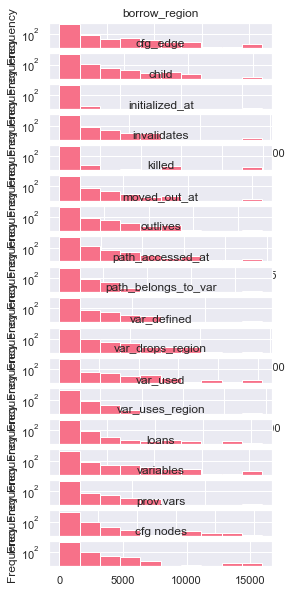

In [30]:
fig, axs = plt.subplots(len(fact_cols), sharey=False, sharex=False, figsize=(4,10))
for c, ax in zip(fact_cols, axs):
    #ax = sns.distplot(df[c], ax=ax, kde=False, rug=True)
    large_df[c].plot.hist(ax=ax)
    ax.set_title(c)
    ax.set(yscale="log")
    #ax.set_xlabel("count")
    
plt.tight_layout()
#fig.set_title("Distribution of input sizes")
plt.savefig("../Report/Graphs/input_sizes_dist.pdf", bbox_inches='tight')

### Clustering

First we do a PCA reduction of the dimensionality of our data into 2 dimensions:

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(
    df.drop(["repository", "function"], axis=1))

In [33]:
reduced_df = pd.DataFrame(reduced_data, columns=["x", "y"]).sample(10000)
x_range = reduced_df.x.min(), reduced_df.x.max()
y_range = reduced_df.y.min(), reduced_df.y.max()

distance = 10000
x_min, y_min = reduced_df.median () - distance / 10
x_max, y_max = reduced_df.median() + distance
x_range = x_min, x_max
y_range = y_min, y_max
x_range, y_range

((-4634.771122048982, 6365.228877951018),
 (-1078.6354560849825, 9921.364543915017))

In [34]:
from datashader import transfer_functions as tf
from colorcet import fire
import holoviews as hv

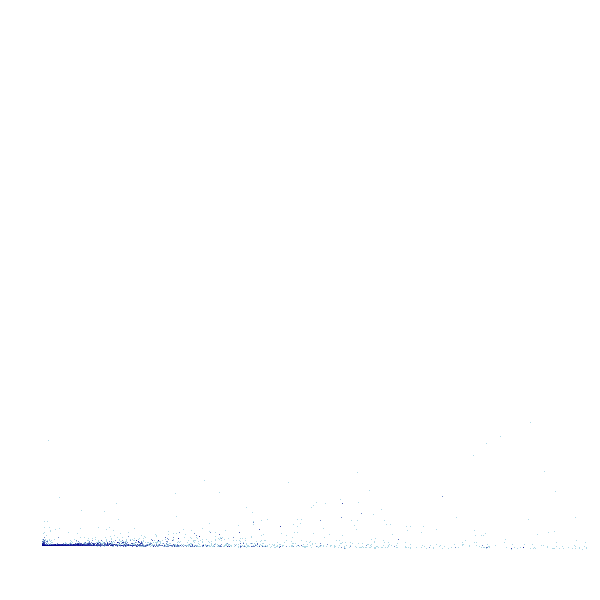

In [35]:
agg = ds.Canvas(x_range=x_range, y_range=y_range).points(reduced_df, "x", "y")
tf.set_background(tf.shade(agg))

In [36]:
#kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
#kmeans.fit(reduced_data)
h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
c = np.random.randint(0, 256, [len(reduced_data), 3])/255.0
#xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)
#plt.figure()
#plt.clf()
#plt.imshow(Z, interpolation='nearest',
#           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           #cmap=palettable.wesanderson.Moonrise1_5.mpl_colormap,
#           aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], '.', markersize=4, c=c)
# Plot the centroids as a white X
#centroids = kmeans.cluster_centers_
#plt.scatter(centroids[:, 0], centroids[:, 1],
#            marker='x', s=169, linewidths=3,
#            color='w', zorder=10)
#plt.title('K-means clustering disk dataset (PCA-reduced data)\n'
#          'Centroids are marked with white cross')
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())
#reduced_data

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11fdb72f0> (for post_execute):


ValueError: Invalid RGBA argument: array([[0.80392157, 0.81960784, 0.56862745],
       [0.0745098 , 0.40784314, 0.14117647],
       [0.10196078, 0.58431373, 0.50196078],
       ...,
       [0.61568627, 0.58039216, 0.96470588],
       [0.42352941, 0.52156863, 0.43921569],
       [0.97647059, 0.3254902 , 0.05882353]])

ValueError: Invalid RGBA argument: array([[0.80392157, 0.81960784, 0.56862745],
       [0.0745098 , 0.40784314, 0.14117647],
       [0.10196078, 0.58431373, 0.50196078],
       ...,
       [0.61568627, 0.58039216, 0.96470588],
       [0.42352941, 0.52156863, 0.43921569],
       [0.97647059, 0.3254902 , 0.05882353]])

<Figure size 432x288 with 1 Axes>

## Correlation Analysis

In [98]:
def plot_linreg(df, x, y, ax):
    X = df[x].values[:,np.newaxis]
    # target data is array of shape (n,) 
    ys = df[y].values
    model = linear_model.LinearRegression()
    model.fit(X, ys)
    ax.plot(X, model.predict(X), color='k', linewidth="2", alpha=0.2)

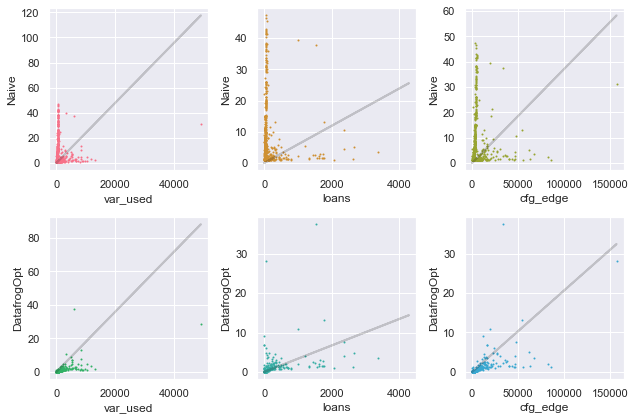

In [106]:
scatter_sample = large_df.sample(1000)
reg_sample = large_df

fig, ((ax_ul, ax_uc, ax_ur), (ax_ll, ax_lc, ax_lr)) = plt.subplots(2, 3, 
                                                     sharey=False, 
                                                     sharex=False, 
                                                     squeeze=True, figsize=(6 * 1.5, 4 * 1.5))
palette = sns.color_palette("husl", 8)

plot_configs = [("var_used", "Naive", ax_ul),
                ("loans", "Naive", ax_uc),
                ("cfg_edge", "Naive", ax_ur),
                
                ("var_used", "DatafrogOpt", ax_ll),
                ("loans", "DatafrogOpt", ax_lc),
                ("cfg_edge", "DatafrogOpt", ax_lr)]

for (x, y, ax), c in zip(plot_configs, palette):
    scatter_sample.plot.scatter(x=x, y=y, c=[c], ax=ax, s=1)
    plot_linreg(df, x=x, y=y, ax=ax)


fig.tight_layout()
plt.savefig("../Report/Graphs/corr_scatter.pdf", bbox_inches='tight')

In [105]:
def normalise_runtimes(df):
    new_df = df.copy()
    new_df[runtime_cols] = \
    (df[runtime_cols] - df[runtime_cols].mean()) \
    / (df[runtime_cols].max() - df[runtime_cols].min())
    return new_df

In [48]:
corr = df.drop(["repository", "function"], axis=1).corr("pearson", min_periods=1)

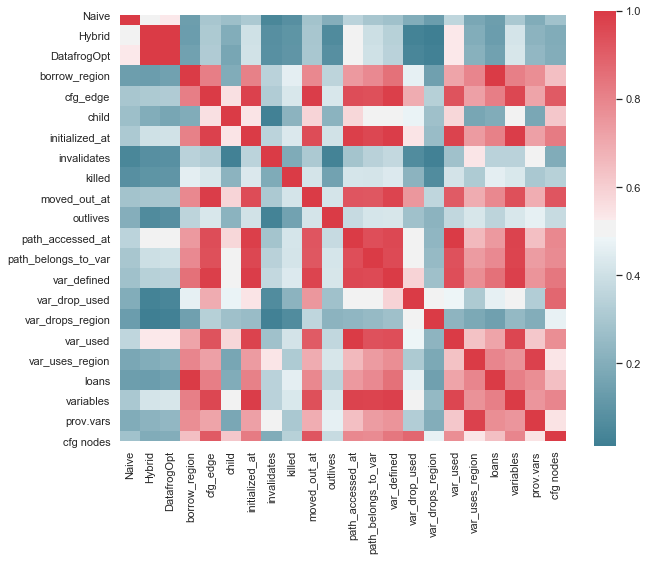

In [49]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=diverging_map,
            square=True, ax=ax)

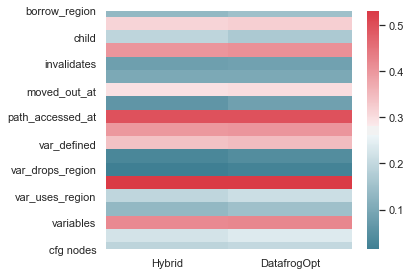

In [107]:
pruned_corr = corr[[*runtime_cols]].drop(runtime_cols).drop("Naive", axis=1)
f, ax = plt.subplots()
_ = sns.heatmap(pruned_corr, 
            mask=np.zeros_like(pruned_corr, dtype=np.bool),
            cmap=diverging_map,
            square=False, ax=ax)
plt.tight_layout()
plt.savefig("../Report/Graphs/corr_heatmap.pdf")

In [74]:
with open("../Report/correlations.tex", "w") as fp:
    pruned_corr.sort_values(by="DatafrogOpt", ascending=False)\
        .to_latex(buf=fp)

In [42]:
import statsmodels.api as sm

In [43]:
# Ordinary least squares regression
model_simple = sm.OLS(large_df.DatafrogOpt, large_df.variables).fit()

# Add a constant term like so:
model = sm.OLS(large_df.DatafrogOpt, sm.add_constant(large_df.variables)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DatafrogOpt   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     2368.
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:16:36   Log-Likelihood:                -6313.1
No. Observations:                3967   AIC:                         1.263e+04
Df Residuals:                    3965   BIC:                         1.264e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.021     -0.351      0.726      -0.048       0.033
variables      0.0008   1.68e-05     48.661      0.000       0.001       0.001
==============================================================================
Omnibus:                     8344.565   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         39014583.102
Skew:                          17.887   Prob(JB):                         0.00
Kurtosis:                     487.515   Cond. No.                     1.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""